In [123]:
# author : Jhanavi Dave (A20515346)

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import seaborn as sns
import plotly
import json
import string
import re
import tensorflow as tf
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')


In [124]:
movies = pd.read_csv('tmdb_5000_movies.csv')
# describing movie row counts, average, deviations, and percentages
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [125]:
movies.nunique()

budget                   436
genres                  1175
homepage                1691
id                      4803
keywords                4222
original_language         37
original_title          4801
overview                4800
popularity              4802
production_companies    3697
production_countries     469
release_date            3280
revenue                 3297
runtime                  156
spoken_languages         544
status                     3
tagline                 3944
title                   4800
vote_average              71
vote_count              1609
dtype: int64

In [126]:
# read end credits csv file from TMDB
credits = pd.read_csv('tmdb_5000_credits.csv')
# describing end credits file of row counts, average, deviations, and percentages
credits.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


In [127]:
credits.nunique()

movie_id    4803
title       4800
cast        4761
crew        4776
dtype: int64

In [128]:
movies.drop_duplicates(inplace=True)

In [129]:
movies['release_date'] = pd.to_datetime(movies['release_date'])

# Extracting the year and store it in a new column 'release_year'
movies['release_year'] = movies['release_date'].dt.year

In [130]:
print(movies['release_year'])


0       2009.0
1       2007.0
2       2015.0
3       2012.0
4       2012.0
         ...  
4798    1992.0
4799    2011.0
4800    2013.0
4801    2012.0
4802    2005.0
Name: release_year, Length: 4803, dtype: float64


In [131]:
credits.drop_duplicates(inplace=True)

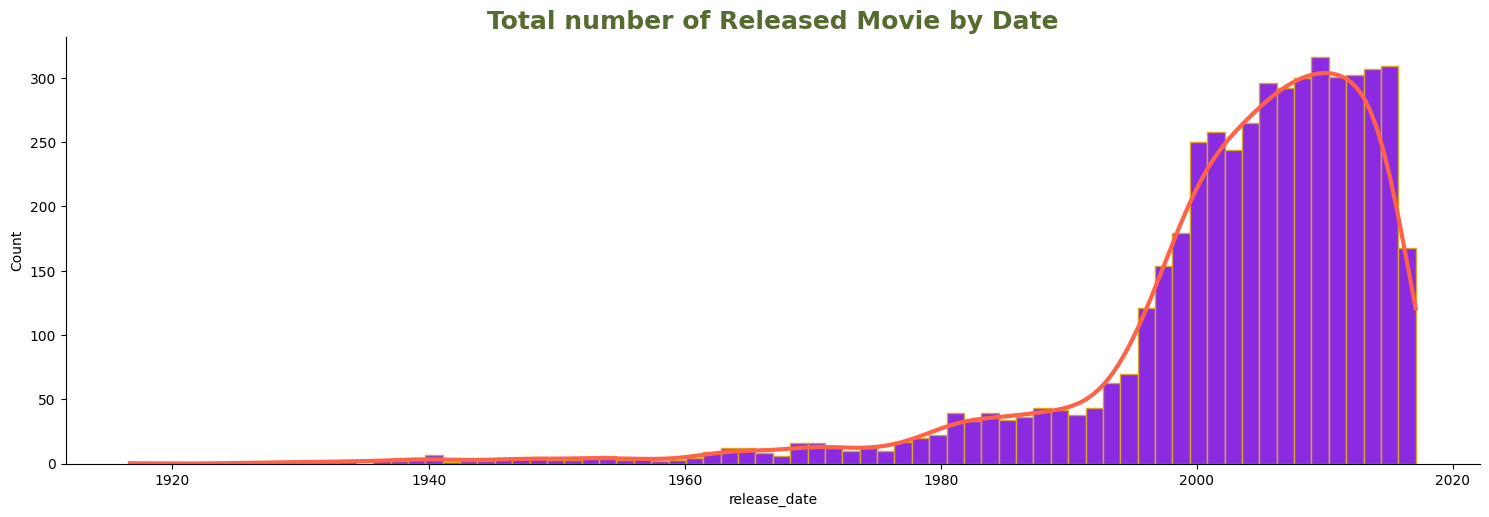

In [132]:
# author : Abhishek Kulkarni (A20516035)

sns.displot(data=movies, x='release_date', kind='hist', kde=True,
            color='#FF6347', facecolor='#8A2BE2', edgecolor='#DAA520', line_kws={'lw': 3, 'color': '#BDB76B'}, aspect=3)
plt.title('Total number of Released Movie by Date', fontsize=18, weight=600, color='#556B2F')
plt.show()


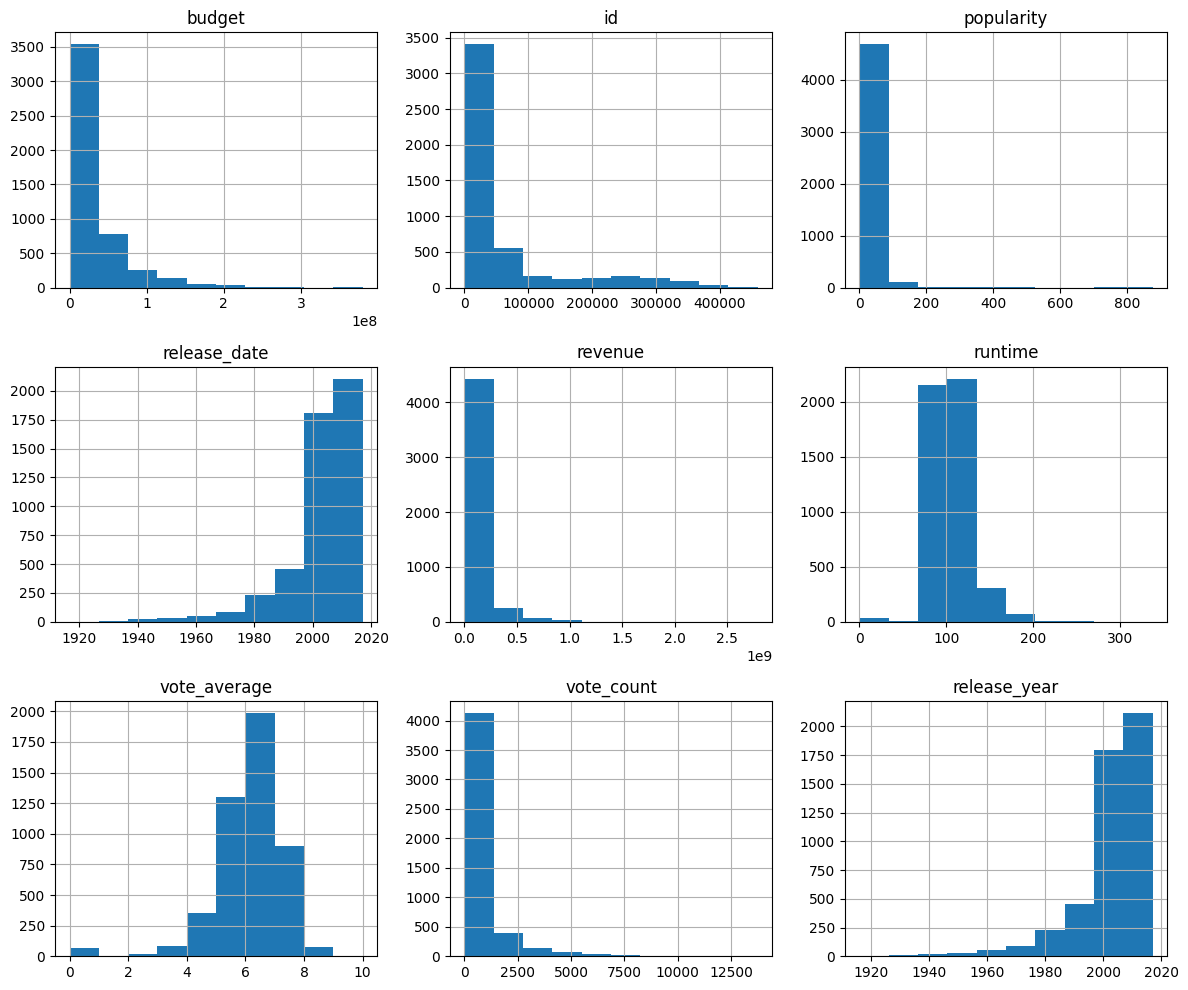

In [133]:


movies.hist(figsize=(12, 10))
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [134]:
# author : Jhanavi Dave (A20515346)

def json_to_str(df, column, new_column_name=None):
    df[column] = df[column].apply(json.loads)
    for index, i in zip(df.index, df[column]):
        list1 = []
        for j in range(len(i)):
            list1.append((i[j]['name']))
        df.loc[index, column] = str(list1)
    if new_column_name:
        df.rename(columns={column: new_column_name}, inplace=True)

def extract_director(crew):
    for i in crew:
        if i['job'] == 'Director':
            return i['name']
    return None

# Apply the function to the columns
json_to_str(movies, 'genres')
json_to_str(movies, 'keywords')
json_to_str(movies, 'production_companies')
json_to_str(credits, 'cast')

credits['crew'] = credits['crew'].apply(json.loads).apply(extract_director)
credits.rename(columns={'crew':'director'}, inplace=True)


In [135]:
# left join credits and movie file data over movie id
movies = movies.merge(credits, left_on='id', right_on='movie_id', how='left')
# new table now consists of merged columns
movies = movies[['id', 'original_title', 'genres', 'cast', 'vote_average', 'director','keywords', 'release_year']]

In [136]:
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')   ###cleaning this column for finding the genre_list
movies['genres'] = movies['genres'].str.split(',')

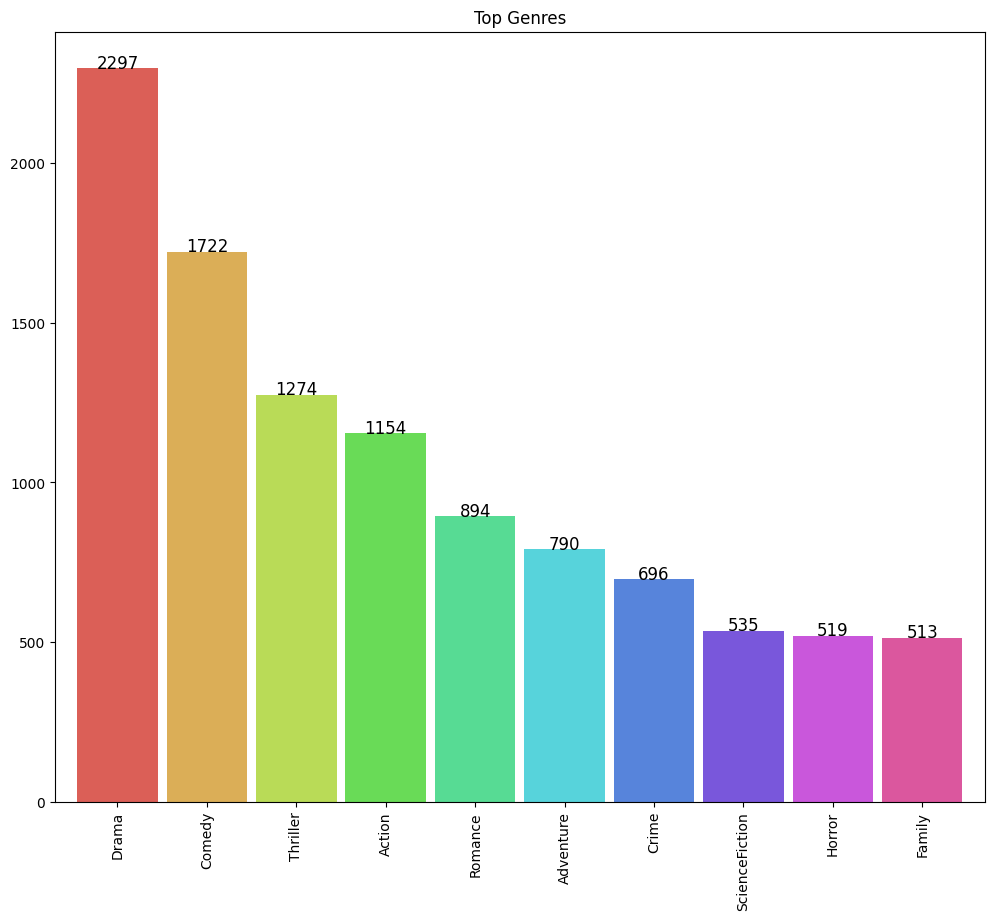

In [137]:
# author : Abhishek Kulkarni (A20516035)

plt.figure(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=False).plot.bar(width=0.9, color=sns.color_palette('hls',10))

# Using a for loop
values = pd.Series(list1).value_counts()[:10].sort_values(ascending=False).values
for i in range(len(values)):
    v = values[i]
    ax.text(i, v + 0.5, v, fontsize=12, ha='center')

plt.title('Top Genres')
plt.show()


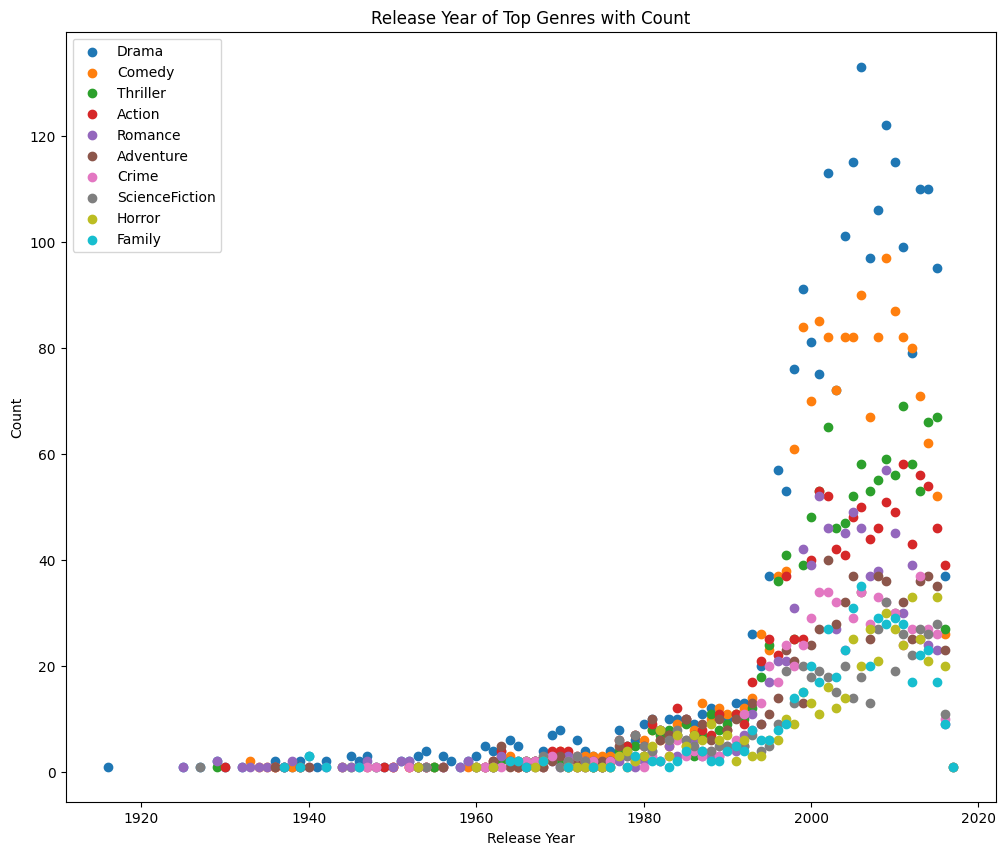

In [138]:


df_genres_years = movies[['release_year', 'genres']]

df_genres_years = df_genres_years.explode('genres')

df_genre_year_count = df_genres_years.groupby(['release_year', 'genres']).size().reset_index(name='count')

# Filter for the top genres
top_genres = pd.Series(list1).value_counts()[:10].index.tolist()
df_genre_year_count_top_genres = df_genre_year_count[df_genre_year_count['genres'].isin(top_genres)]

plt.figure(figsize=(12,10))
for genre in top_genres:
    df_genre = df_genre_year_count_top_genres[df_genre_year_count_top_genres['genres'] == genre]
    plt.scatter(df_genre['release_year'], df_genre['count'], label=genre)
plt.legend()
plt.title('Release Year of Top Genres with Count')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()


In [139]:
# author : Jhanavi Dave (A20515346)

for i,j in zip(movies['genres'],movies.index):
    list2=[]
    list2=i
    list2.sort()
    movies.loc[j,'genres']=str(list2)
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

In [140]:
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]

    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #now we have a list with unique genres

['Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'Crime',
 'Drama',
 'Thriller',
 'Animation',
 'Family',
 'Western']

In [141]:
# author : Abhishek Kulkarni (A20516035)

###one hot encoding for the multiple labels
def binary(genre_list):
    binaryList = []

    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)

    return binaryList
# convert genre to binary
movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))
movies['genres_bin'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

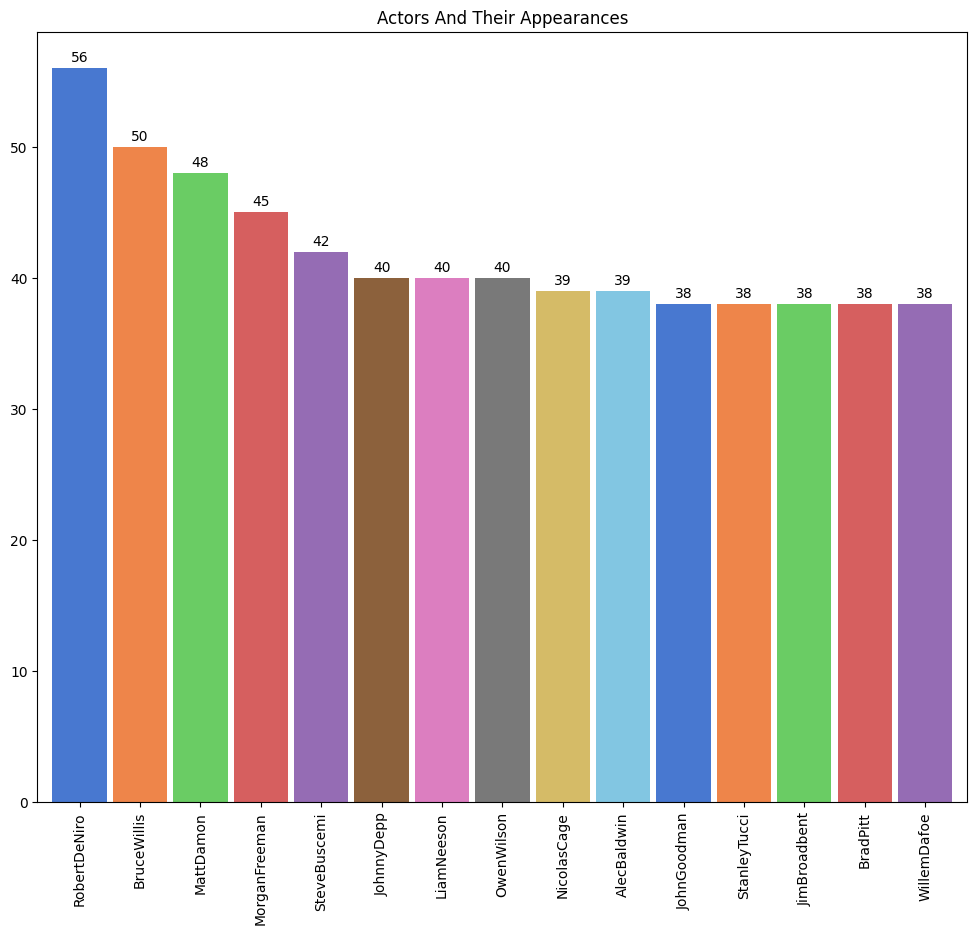

In [142]:
def plot_top_actors(movies):
    movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
    movies['cast'] = movies['cast'].apply(lambda x: re.split(',(?![a-zA-Z]+\.)', x))
    #movies = movies[movies.cast != " "]
    list1 = []
    for i in movies['cast']:
        list1.extend(i)

    while("" in list1):
        list1.remove("")

    values = pd.Series(list1).value_counts()[:15].sort_values(ascending=False).values
    labels = pd.Series(list1).value_counts()[:15].sort_values(ascending=False).index

    plt.subplots(figsize=(12,10))
    ax = pd.Series(list1).value_counts()[:15].sort_values(ascending=False).plot.bar(width=0.9, color=sns.color_palette('muted',40))
    for i in range(len(values)):
        ax.text(i, values[i] + 0.5, values[i], fontsize=10, color='black', ha='center')
    plt.title('Actors And Their Appearances')
    plt.show()

plot_top_actors(movies)


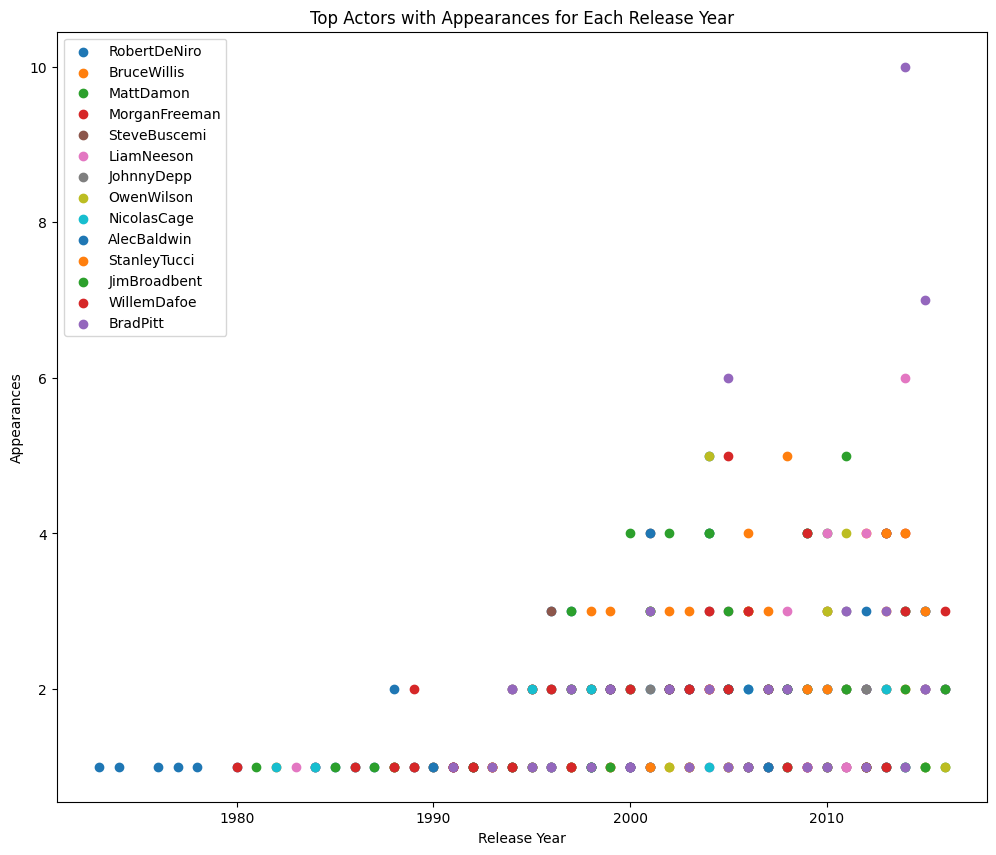

In [143]:
def plot_actor_appearances(movies):

    df_cast_years = movies[['release_year', 'cast']]
    df_cast_years = df_cast_years.explode('cast')

    df_actor_year_count = df_cast_years.groupby(['release_year', 'cast']).size().reset_index(name='count')

    list1 = []
    for i in movies['cast']:
        list1.extend(i)
    top_actors = pd.Series(list1).value_counts()[:15].index.tolist()
    df_actor_year_count_top_actors = df_actor_year_count[df_actor_year_count['cast'].isin(top_actors)]

    plt.figure(figsize=(12,10))
    for actor in top_actors:
        df_actor = df_actor_year_count_top_actors[df_actor_year_count_top_actors['cast'] == actor]
        plt.scatter(df_actor['release_year'], df_actor['count'], label=actor)
    plt.legend()
    plt.title('Top Actors with Appearances for Each Release Year')
    plt.xlabel('Release Year')
    plt.ylabel('Appearances')
    plt.show()

# Call the function
plot_actor_appearances(movies)


In [144]:
# author : Jhanavi Dave (A20515346)

def process_cast_and_create_binary(movies):
    # Processing 'cast' column and create a sorted list
    for i, j in zip(movies['cast'], movies.index):
        list2 = i[:4]
        movies.loc[j, 'cast'] = str(list2)
    movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ', '').str.replace("'", '')
    movies['cast'] = movies['cast'].str.split(',')
    for i, j in zip(movies['cast'], movies.index):
        list2 = i
        list2.sort()
        movies.loc[j, 'cast'] = str(list2)
    movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ', '').str.replace("'", '')

    castList = []
    for index, row in movies.iterrows():
        cast = row["cast"]
        for i in cast:
            if i not in castList:
                castList.append(i)

    def binary(cast_list):
        binaryList = []
        for actor in castList:
            if actor in cast_list:
                binaryList.append(1)
            else:
                binaryList.append(0)
        return binaryList

    movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x))

    return movies

movies = process_cast_and_create_binary(movies)
print(movies['cast_bin'].head())


0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...
2    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3    [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...
4    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...
Name: cast_bin, dtype: object


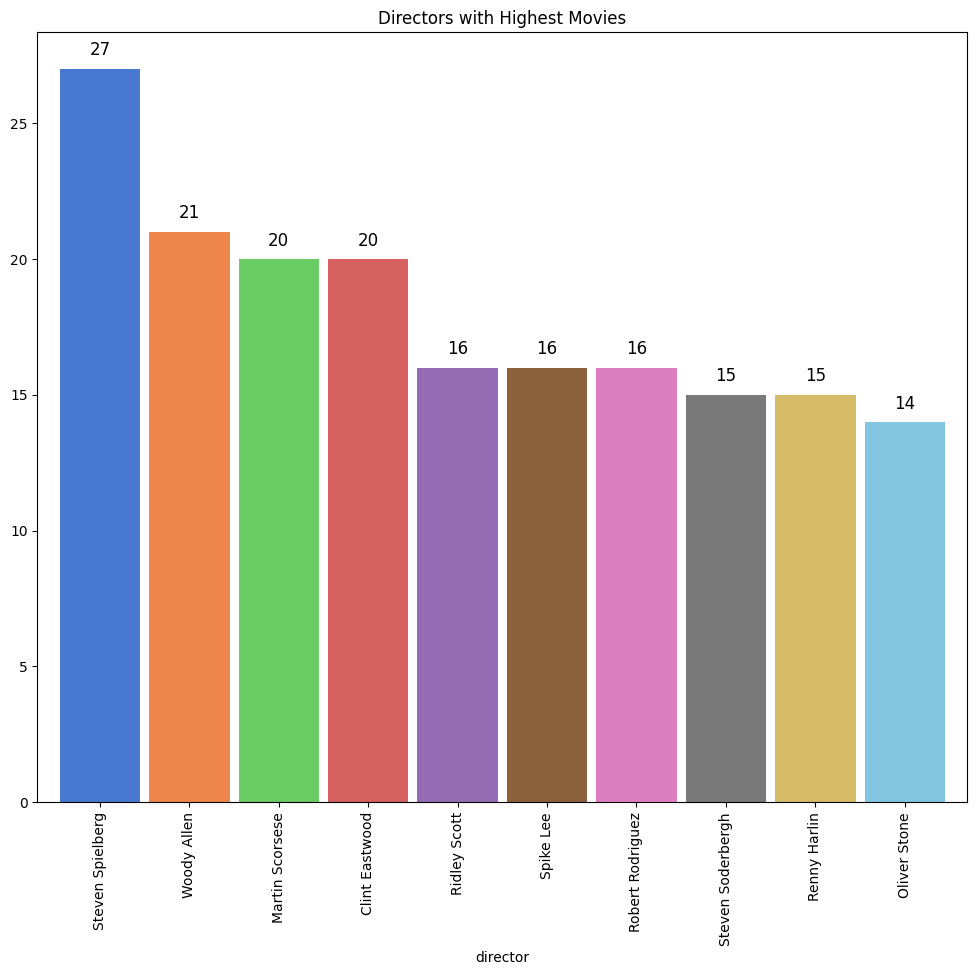

In [145]:
def xstr(s):
    if s is None:
        return ''
    return str(s)

movies['director'] = movies['director'].apply(xstr)

plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=False).plot.bar(width=0.9, color=sns.color_palette('muted',40))

values = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=False).values
for i in range(len(values)):
    ax.text(i, values[i] + 0.5, values[i], fontsize=12, color='black', ha='center')

plt.title('Directors with Highest Movies')
plt.show()


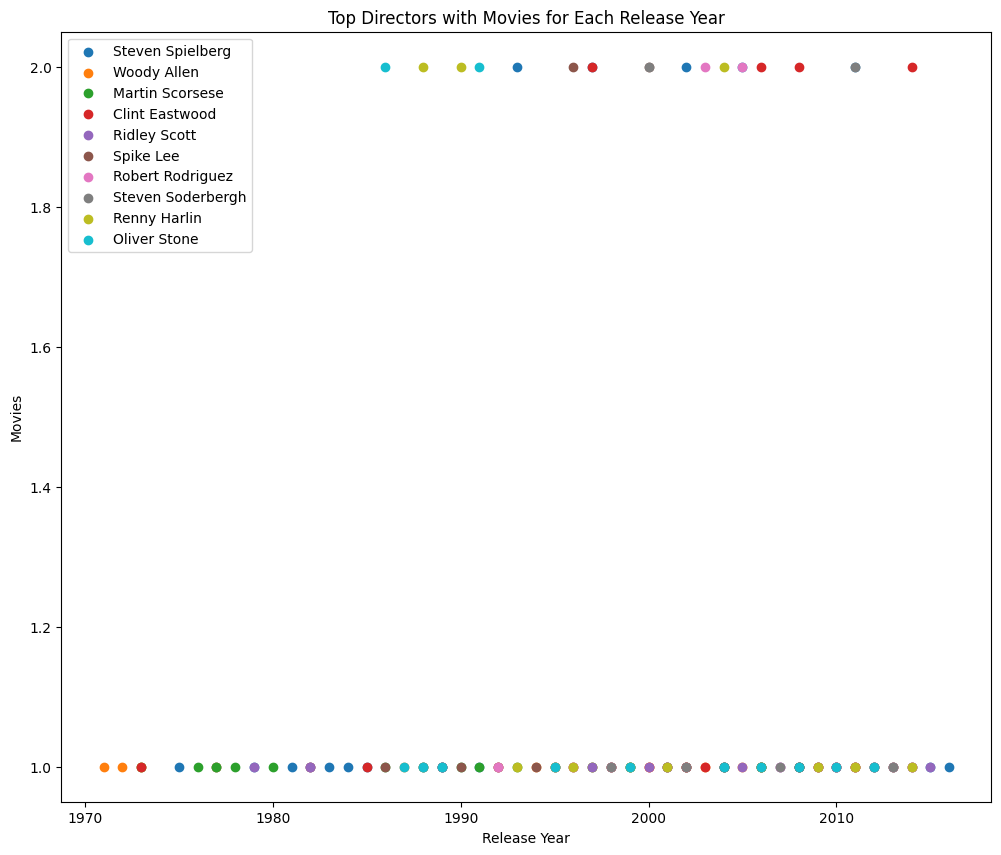

In [146]:
def xstr(s):
    if s is None:
        return ''
    return str(s)

def plot_director_movies(movies):

    movies['director'] = movies['director'].apply(xstr)

    df_director_years = movies[['release_year', 'director']]

    df_director_year_count = df_director_years.groupby(['release_year', 'director']).size().reset_index(name='count')

    top_directors = movies[movies['director']!=''].director.value_counts()[:10].index.tolist()

    plt.figure(figsize=(12,10))
    for director in top_directors:
        df_director = df_director_year_count[df_director_year_count['director'] == director]
        plt.scatter(df_director['release_year'], df_director['count'], label=director)
    plt.legend()
    plt.title('Top Directors with Movies for Each Release Year')
    plt.xlabel('Release Year')
    plt.ylabel('Movies')
    plt.show()

plot_director_movies(movies)


In [147]:
directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)

In [148]:
def binary(director_list, unique_directors):
    return [1 if direct in director_list else 0 for direct in unique_directors]

directorList = []
i = 0
while i < len(movies['director']):
    if movies['director'][i] not in directorList:
        directorList.append(movies['director'][i])
    i += 1

movies['director_bin'] = movies['director'].apply(lambda x: binary(x, directorList))
movies.head()


,id,original_title,genres,cast,vote_average,director,keywords,release_year,genres_bin,cast_bin,director_bin
0,19995,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]","SamWorthington,SigourneyWeaver,StephenLang,Zoe...",7.2,James Cameron,"['culture clash', 'future', 'space war', 'spac...",2009.0,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,285,Pirates of the Caribbean: At World's End,"[Action, Adventure, Fantasy]","JohnnyDepp,KeiraKnightley,OrlandoBloom,Stellan...",6.9,Gore Verbinski,"['ocean', 'drug abuse', 'exotic island', 'east...",2007.0,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,206647,Spectre,"[Action, Adventure, Crime]","ChristophWaltz,DanielCraig,LéaSeydoux,RalphFie...",6.3,Sam Mendes,"['spy', 'based on novel', 'secret agent', 'seq...",2015.0,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","AnneHathaway,ChristianBale,GaryOldman,MichaelC...",7.6,Christopher Nolan,"['dc comics', 'crime fighter', 'terrorist', 's...",2012.0,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,49529,John Carter,"[Action, Adventure, ScienceFiction]","LynnCollins,SamanthaMorton,TaylorKitsch,Willem...",6.1,Andrew Stanton,"['based on novel', 'mars', 'medallion', 'space...",2012.0,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [149]:
# author : Abhishek Kulkarni (A20516035)

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

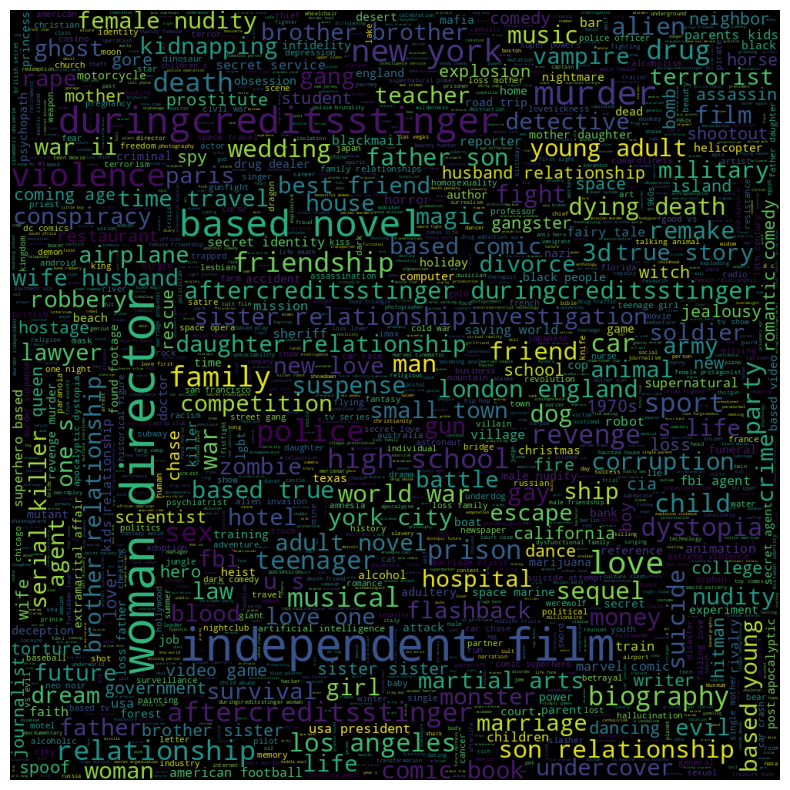

In [150]:
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [151]:
# author : Abhishek Kulkarni (A20516035)

def process_keywords_and_create_binary(movies):

    movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
    movies['keywords'] = movies['keywords'].str.split(',')

    for i, j in zip(movies['keywords'], movies.index):
        list2 = i
        movies.loc[j, 'keywords'] = str(list2)

    movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
    movies['keywords'] = movies['keywords'].str.split(',')

    for i, j in zip(movies['keywords'], movies.index):
        list2 = i
        list2.sort()
        movies.loc[j, 'keywords'] = str(list2)

    movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
    movies['keywords'] = movies['keywords'].str.split(',')


    words_list = []                                  # Creating a list of all unique keywords
    for index, row in movies.iterrows():
        genres = row["keywords"]
        for genre in genres:
            if genre not in words_list:
                words_list.append(genre)


    def binary(words):                                # Defining a function to create a binary list for each movie
        binaryList = []
        for genre in words_list:
            if genre in words:
                binaryList.append(1)
            else:
                binaryList.append(0)
        return binaryList

    movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x))

    movies = movies[(movies['vote_average']!=0)]    #removing the movies with 0 score and without director names
    movies = movies[movies['director']!='']

    return movies

movies = process_keywords_and_create_binary(movies)


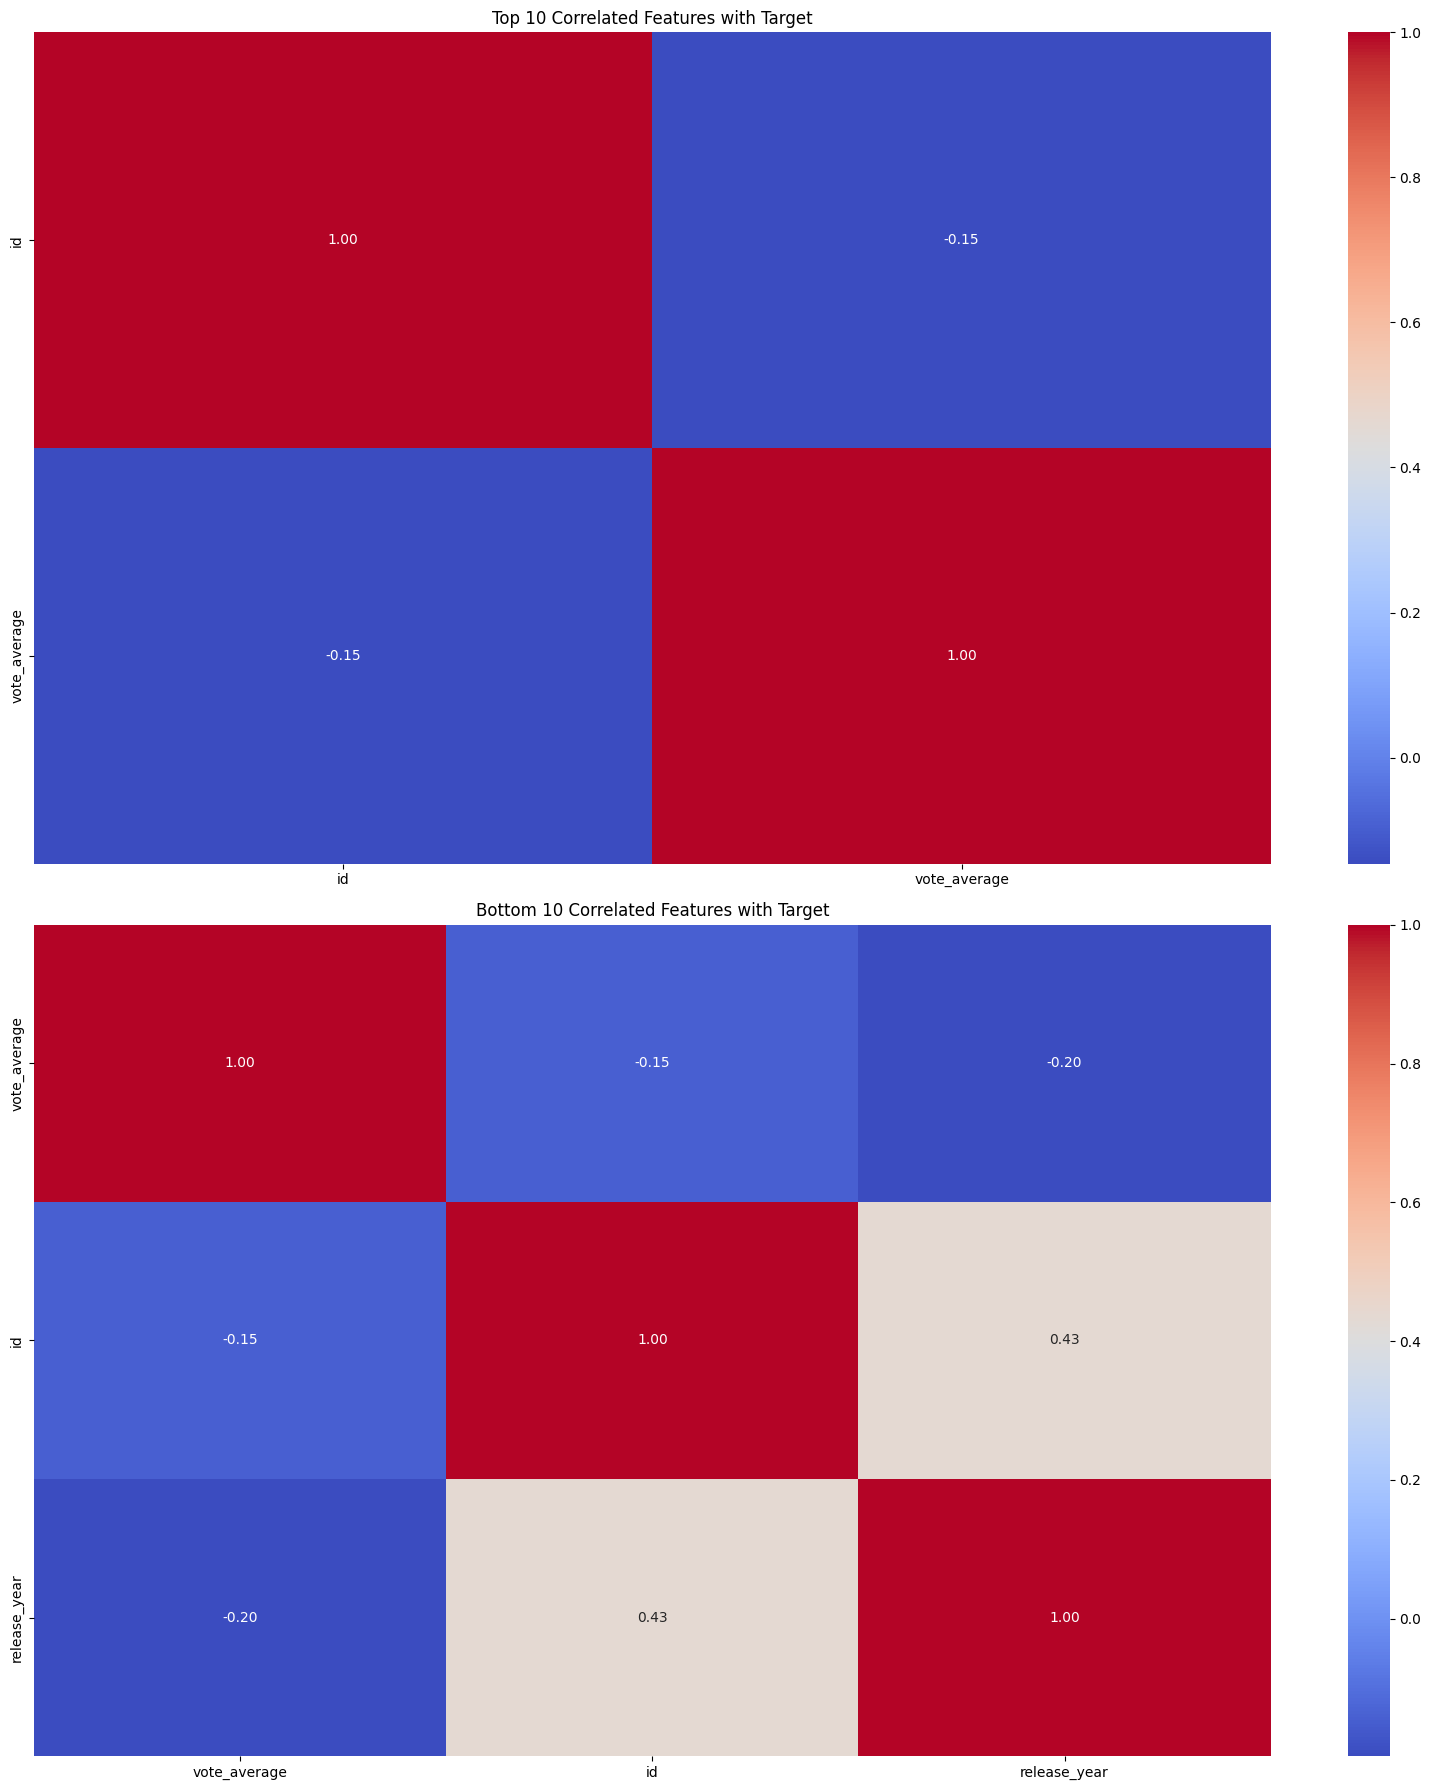

In [152]:
# author : Jhanavi Dave (A20515346)

####feature selection

def plot_correlation(movies):

    numeric_columns = movies.select_dtypes(include=[np.number])

    # Calculate correlation matrix
    correlation_matrix = numeric_columns.corr()
    correlation_with_target = correlation_matrix['release_year']

    top_10_correlated = correlation_with_target.abs().sort_values(ascending=False).head(10)[1:]  # Exclude the target itself

    bottom_10_correlated = correlation_with_target.abs().sort_values(ascending=True).head(10)

    top_10_df = numeric_columns[top_10_correlated.index]
    bottom_10_df = numeric_columns[bottom_10_correlated.index]

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))

    sns.heatmap(top_10_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
    axes[0].set_title('Top 10 Correlated Features with Target')

    sns.heatmap(bottom_10_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1])
    axes[1].set_title('Bottom 10 Correlated Features with Target')

    plt.tight_layout()

    plt.show()


plot_correlation(movies)


In [153]:
##similarity
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]

    genreDistance = spatial.distance.cosine(a['genres_bin'], b['genres_bin'])

    scoreDistance = spatial.distance.cosine(a['cast_bin'], b['cast_bin'])

    directDistance = spatial.distance.cosine(a['director_bin'],  b['director_bin'])

    wordsDistance = spatial.distance.cosine(a['words_bin'], b['words_bin'])
    return genreDistance + directDistance + scoreDistance + wordsDistance

In [154]:
Similarity(45, 53) #checking similarity between any 2 random movies

2.5745004381382195

In [155]:
print(movies.iloc[45])
print(movies.iloc[53])

id                                                            72190
original_title                                          World War Z
genres            [Action, Drama, Horror, ScienceFiction, Thriller]
cast              AbigailHargrove,BradPitt,MireilleEnos,Sterling...
vote_average                                                    6.7
director                                               Marc Forster
keywords          [apocalypse, dystopia, multipleperspectives, n...
release_year                                                 2013.0
genres_bin        [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...
cast_bin          [1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, ...
director_bin      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
words_bin         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 45, dtype: object
id                                                              217
original_title    Indiana Jones and the Kingdom of the Crystal S...
genres                  

In [156]:
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
movies.head()

,original_title,genres,vote_average,genres_bin,cast_bin,new_id,director,director_bin,words_bin
0,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]",7.2,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,James Cameron,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Pirates of the Caribbean: At World's End,"[Action, Adventure, Fantasy]",6.9,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...",1,Gore Verbinski,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Spectre,"[Action, Adventure, Crime]",6.3,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2,Sam Mendes,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",7.6,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",3,Christopher Nolan,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,John Carter,"[Action, Adventure, ScienceFiction]",6.1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...",4,Andrew Stanton,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [157]:
####KNN
# author : Jhanavi Dave (A20515346)
import operator
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

def predict_score(name, rmse_calc):
    matching_movies = movies[movies['original_title'].str.contains(name)]
    if matching_movies.empty:
        print(f"No movie found with title containing '{name}'")
        return None
    new_movie = matching_movies.iloc[0].to_frame().T
    def getNeighbors(baseMovie, K):
        distances = []
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors




    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    if rmse_calc == 0:

      for neighbor in neighbors[:10]:
          movie = movies.iloc[neighbor[0]]
          print(f"Title: {movie['original_title']}")
          print(f"Director: {movie['director']}")

          if 'keywords' in movie:
              print(f"Keywords: {movie['keywords']}")

          if 'runtime' in movie:
              print(f"Runtime: {movie['runtime']} minutes")

          if 'cast' in movie:
              print(f"Actors: {movie['cast']}")

          print(f"Genres: {movie['genres']}")
          print(f"Rating: {movie['vote_average']:.2f}/10")
          print('---')
          # avgRating = avgRating + movie['vote_average']
      print("Predicted Rating based on Neighbour Movies:")

    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2]
    avgRating = avgRating/K

    return avgRating

In [158]:
# author : Abhishek Kulkarni (A20516035)

from sklearn.metrics import mean_squared_error
from math import sqrt
def calculate_rmse_mape_for_top_movies(data, top_n):
    top_movies = data.sort_values(by='vote_average', ascending=False).head(top_n)
    predictions = []
    targets = []
    for _, movie in top_movies.iterrows():
        predicted_score = predict_score(movie['original_title'], 1)
        if predicted_score is not None:
            actual_score = movie['vote_average']
            predictions.append(predicted_score)
            targets.append(actual_score)
    rmse = sqrt(mean_squared_error(targets, predictions))
    mape = np.mean(np.abs((np.array(targets) - np.array(predictions)) / np.array(targets))) * 100
    return rmse, mape

rmse, mape = calculate_rmse_mape_for_top_movies(movies, 50)
print(f'Root Mean Squared Error for top 50 movies: {rmse}')
print(f'Mean Absolute Percentage Error for top 50 movies: {mape}%')

No movie found with title containing 'Call + Response'
Root Mean Squared Error for top 50 movies: 1.8289385792121646
Mean Absolute Percentage Error for top 50 movies: 19.751923255213462%


In [159]:
movie_title = input("Enter the movie title: ")
predict_score(movie_title, 0)

Enter the movie title: Notting Hill
Title: Morning Glory
Director: Roger Michell
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 6.10/10
---
Title: About a Boy
Director: Chris Weitz
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 6.60/10
---
Title: Love Actually
Director: Richard Curtis
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 7.00/10
---
Title: Forrest Gump
Director: Robert Zemeckis
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 8.20/10
---
Title: When Harry Met Sally...
Director: Rob Reiner
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 7.30/10
---
Title: Bridget Jones's Diary
Director: Sharon Maguire
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 6.50/10
---
Title: Bend It Like Beckham
Director: Gurinder Chadha
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 6.20/10
---
Title: Much Ado About Nothing
Director: Kenneth Branagh
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 7.20/10
---
Title: Cyrus
Director: Jay Duplass
Genres: ['Comedy', 'Drama', 'Romance']
Rating: 6.10/10
---
Titl

6.88